# DCGAN (Deep Convolutional GAN) Face

### Step 1: 載入相關套件

In [15]:
import os, torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision import datasets
from torchvision import utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### Step 2: 設定參數

In [16]:
DATASET_PATH = "../data/img_align_celeba/" # path to the dataset
# PATH_DATASETS = "../data" # path to the dataset
BATCH_SIZE = 128 # batch size 128
image_size = 64 # image size 64x64
# check if GPU is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available.")
else:
    device = torch.device("cpu")
    print("MPS backend is not available.")

MPS backend is available.


### Step 3: 定義神經網路參數

In [17]:
nz = 100 # size of the latent z vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator
nc = 3 # number of channels in the training images

### Step 4: 下載訓練影像並放
- [下載點](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ)
- 下載後解壓縮並放到你自己指定的目錄下

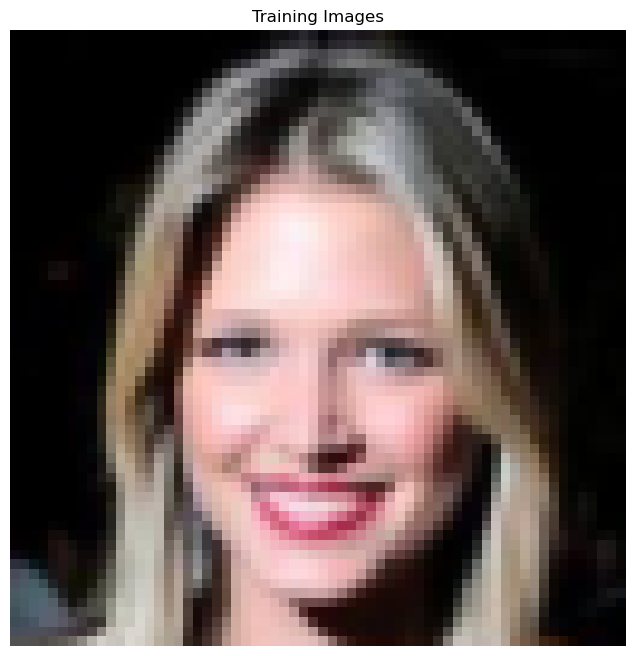

In [20]:
# build a transformer to preprocess the images
transform1 = transforms.Compose([
    transforms.Resize(image_size), # resize the images to 64x64
    transforms.CenterCrop(image_size),# resize the images to 64x64
    transforms.ToTensor(), # convert the images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize the images 
])

# load the dataset
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img
dataset = CelebADataset(root_dir=DATASET_PATH, transform=transform1)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], 
                                        padding=2, 
                                        normalize=True).cpu(),(1,2,0)));

### Step 5: 定義神經網路權重初始值

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Step 6: 定義`生成神經網路`

In [26]:
use_bias = False
class Generator( nn.Module ):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Step 7: 定義 `判別神經網路` 

In [27]:
# using LeakyReLU activation function to avoid sparse gradients
class Discriminator(nn.Module):
    def __init__(self, nc = 3, ndf=ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=use_bias),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=use_bias),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=use_bias),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=use_bias),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=use_bias),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

### Step 8: 設定 Lossy 函式及 Optimizer 

In [28]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Step 9: 模型訓練

In [33]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0
niter = 10 

for epoch in range( niter ):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data.to(device)  # Ensure data is on the correct device
        # print(f"Shape of real_cpu: {real_cpu.shape}")  # Debugging

        # Check and fix dimensions
        if len(real_cpu.shape) == 3:  # If batch dimension is missing
            real_cpu = real_cpu.unsqueeze(0)

        b_size = real_cpu.size(0)  # Batch size
        label = torch.full((b_size,), real_label, device=device)

        output = netD(real_cpu).view(-1)  # Forward pass through discriminator
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizer_D.step()

        # Update generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()


        if i % 50 == 0:
            print(f"[{epoch}/{niter}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1}/{D_G_z2}")

        if i % 100 == 0:
            vutils.save_image(real_cpu, f"results/DCGAN_Face_real_samples.png", normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(), f"results/DCGAN_Face_fake_samples_epoch_{epoch}.png", normalize=True)
    torch.save(netG.state_dict(), f"results/DCGAN_Face_netG_epoch_{epoch}.pth")
    torch.save(netD.state_dict(), f"results/DCGAN_Face_netD_epoch_{epoch}.pth")

[0/10][0/1583] Loss_D: 0.7434070706367493 Loss_G: 10.258442878723145 D(x): 0.6890971064567566 D(G(z)): 0.0033822953701019287/0.0008059905958361924
[0/10][50/1583] Loss_D: 0.5252033472061157 Loss_G: 2.509110927581787 D(x): 0.7613164186477661 D(G(z)): 0.12253759056329727/0.10686498880386353
[0/10][100/1583] Loss_D: 0.3993573486804962 Loss_G: 4.569979667663574 D(x): 0.8995751142501831 D(G(z)): 0.18046949803829193/0.02401256561279297
[0/10][150/1583] Loss_D: 0.44513607025146484 Loss_G: 3.3952577114105225 D(x): 0.797402024269104 D(G(z)): 0.11521146446466446/0.071736641228199
[0/10][200/1583] Loss_D: 0.633549690246582 Loss_G: 2.8295469284057617 D(x): 0.7274032831192017 D(G(z)): 0.14642636477947235/0.10006862878799438
[0/10][250/1583] Loss_D: 0.6479227542877197 Loss_G: 3.0412349700927734 D(x): 0.7387542724609375 D(G(z)): 0.204415962100029/0.08672815561294556
[0/10][300/1583] Loss_D: 0.5159415602684021 Loss_G: 3.3027610778808594 D(x): 0.7216546535491943 D(G(z)): 0.06778393685817719/0.064204268

### Step 10: 新資料預測
- 使用生成模型產出圖像

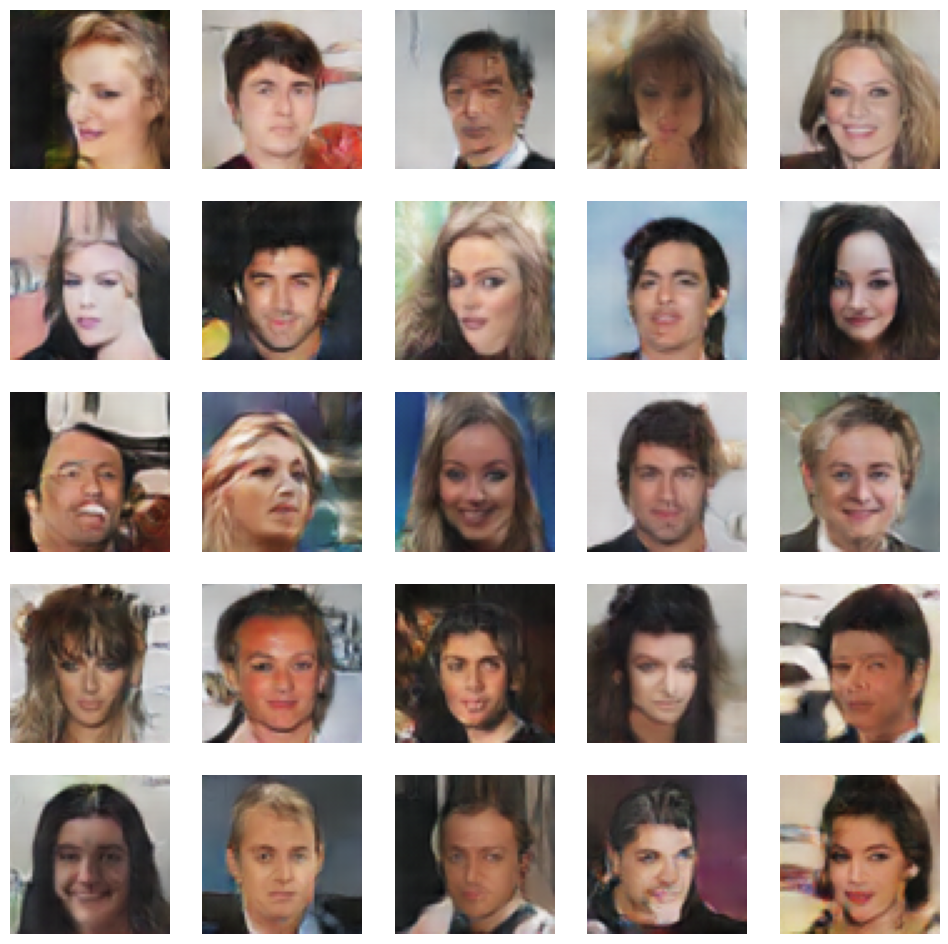

In [34]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = netG(fixed_noise).clamp(min=-1, max=1)
fake_images_np = fake_images.cpu().detach()
fake_images_np = fake_images_np.reshape(-1, 3, image_size, image_size)
fake_images_np = torch.permute( fake_images_np, (0, 2, 3, 1) ).detach().numpy()
fake_images_np = (fake_images_np + 1) * 0.5
R, C = 5, 5
fig, axes = plt.subplots(R, C, figsize=(12, 12))
for i  in range(batch_size):
    plt.subplot(R, C, i+1)
    plt.axis("off")
    plt.imshow(fake_images_np[i])
plt.show()